# Sorting Example using Dask

Ensure Dask is installed and the tutorials examples are running before executing this.

This example demonstrates a two stage sorting technique.  The first stage tasks opens a file to sort the numbers and the second stage task takes the single-file sorted lists and merges them into one list.

In [2]:
import dask.dataframe as dd
from dask.distributed import Client
import dask

In [3]:
client = Client()
client

/Users/neil/Projects/dask-tutorial/.venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58525 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58525/status,
Dashboard: http://127.0.0.1:58525/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58526,Workers: 4
Dashboard: http://127.0.0.1:58525/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58537,Total threads: 2
Dashboard: http://127.0.0.1:58541/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58529,


In [4]:
def sort_integers_in_file(file_path):
    import time
    time.sleep(3)
    with open(file_path, "r") as f:
        # first sort integers in file as they are read
        sorted_integers = []
        n = 0
        for line in f:
            integer = int(line)
            index_to_insert = n
            # TODO: since the integers are sorted, could use binary search to optimize the following code
            for i, v in enumerate(sorted_integers):
                if integer < v:
                    index_to_insert = i
                    break
            n = n + 1
            sorted_integers.insert(index_to_insert, integer)
    return sorted_integers

In [5]:

def second_stage_sort(sorted_lists):
    print(f"First stage sort results: {sorted_lists}")
    sorted_lists = list(sorted_lists)
    final_sort = []

    while True:
        min_index = 0
        min_value = sorted_lists[min_index][0]

        for i, sorted_list in enumerate(sorted_lists[1:]):
            if sorted_list[0] < min_value:
                min_index = i + 1
                min_value = sorted_list[0]
        final_sort.append(min_value)
        del sorted_lists[min_index][0]

        if len(sorted_lists[min_index]) == 0:
            del sorted_lists[min_index]
            if len(sorted_lists) == 0:
                break
    return final_sort

In [6]:
data_files_to_sort = ["data/numbers/1.txt", "data/numbers/2.txt", "data/numbers/3.txt", "data/numbers/4.txt"]

sort_tasks = []
for file_to_sort in data_files_to_sort:
    task = dask.delayed(sort_integers_in_file)(file_to_sort)

    sort_tasks.append(task)

final_sort_task = dask.delayed(second_stage_sort)(sort_tasks)

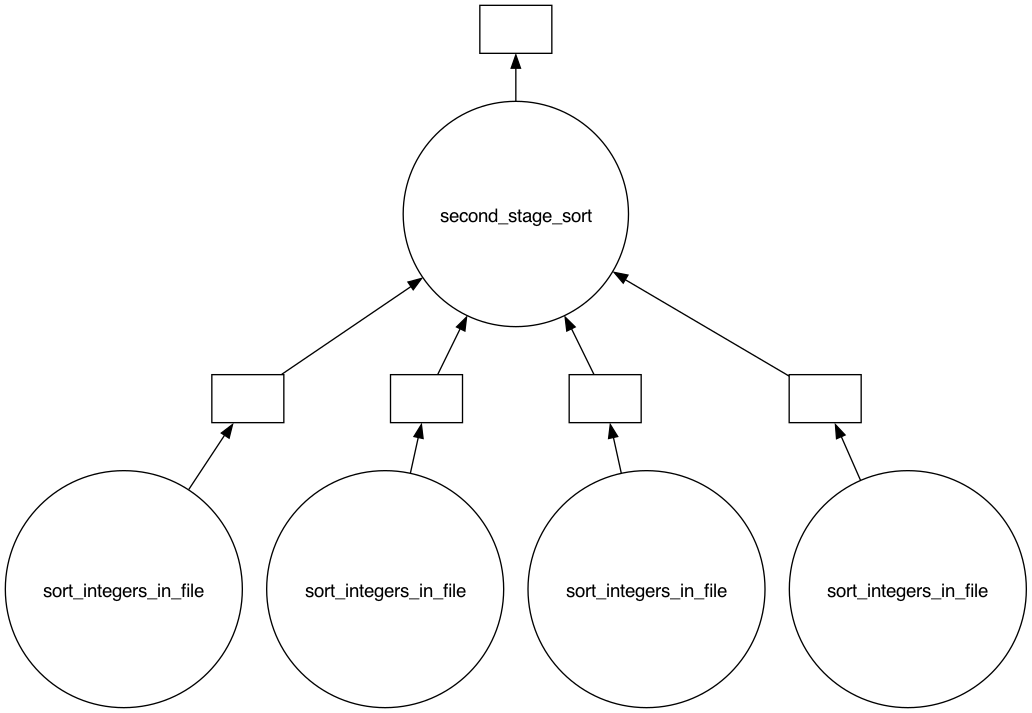

In [7]:
final_sort_task.visualize()

In [8]:
final_sort_task.dask

HighLevelGraph with 5 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x163e7e6b0>
 0. sort_integers_in_file-0989ea8e-2ebb-4089-bd2e-967275cc764a
 1. sort_integers_in_file-91435c9b-4775-4f93-8a1e-44994c5f6405
 2. sort_integers_in_file-f5a5c977-f9f1-4811-aa5a-b989edd3d657
 3. sort_integers_in_file-7ec3cbaa-ba83-4fc2-ab06-84f614749d99
 4. second_stage_sort-12de4e46-78ab-4dab-8107-a879e8188bc6

In [35]:
final_sort_task.compute()

First stage sort results: [[2, 5, 11, 44, 333], [1, 44, 222, 3333, 55555], [3, 4, 22, 11111, 5555555], [2222, 33333, 55555, 444444, 1111111]]


[1,
 2,
 3,
 4,
 5,
 11,
 22,
 44,
 44,
 222,
 333,
 2222,
 3333,
 11111,
 33333,
 55555,
 55555,
 444444,
 1111111,
 5555555]